In [1]:
import os
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
import torchvision as tv
import torchvision.models as models
from torchvision.models import resnet50, inception_v3
from skimage.io import imread
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm
from PIL import Image

try:
    import onnx
except:
    %pip install onnx
    import onnx
    
import warnings
warnings.filterwarnings("ignore")
    
    
# Ensure reproducibility
rs = 42
np.random.seed(rs)
torch.manual_seed(rs)
torch.cuda.manual_seed(rs)

DATADIR = "//kaggle/input/skin-cancer-mnist-ham10000/"
print(os.listdir(DATADIR))

['hmnist_8_8_RGB.csv', 'hmnist_28_28_RGB.csv', 'HAM10000_images_part_1', 'ham10000_images_part_1', 'hmnist_8_8_L.csv', 'HAM10000_images_part_2', 'ham10000_images_part_2', 'hmnist_28_28_L.csv', 'HAM10000_metadata.csv']


# Create Data CSV

In [2]:
data = pd.read_csv(DATADIR+"HAM10000_metadata.csv")
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


Adding 3 auxiliary columns

In [3]:
all_image_path = glob(os.path.join(DATADIR, 'HAM10000_images_part_1', '*.jpg'))
all_image_path.extend(glob(os.path.join(DATADIR, 'HAM10000_images_part_2', '*.jpg')))
imageid_path_dict = {i.split('/')[-1][:-4]: i for i in all_image_path}


lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

data['path'] = data['image_id'].map(imageid_path_dict.get)
data['c_type'] = data['dx'].map(lesion_type_dict.get)

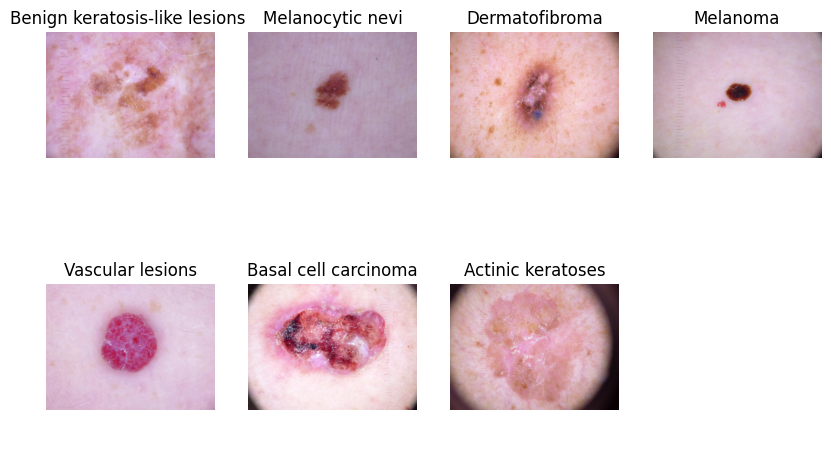

In [4]:
# Displaying unique classes
unique_classes = data["dx"].unique()
class_samples = {i: list(data[data["dx"] == i]["path"])[0] for i in unique_classes}

fig, axs = plt.subplots(2, 4, figsize=(10, 6))
for i, class_ in enumerate(class_samples):
    img = Image.open(class_samples[class_])
#     img = tv.transforms.Resize(IMG_SIZE)(img)
#     img = augmentations[aug](img)
    axs[i // 4, i % 4].imshow(img)
    axs[i // 4, i % 4].axis("off")
    axs[i // 4, i % 4].set_title(lesion_type_dict[class_])
axs[1,3].axis("off")

plt.show()

In [5]:
# One-hot encode the labels
labels_encoded = pd.get_dummies(data['dx'])

# Concatenate the one-hot encoded labels DataFrame with the original DataFrame
data = pd.concat([data, labels_encoded], axis=1)

class_idx_dict = {header:i for i, header in enumerate(list(labels_encoded.columns))}
idx_class_dict = {i:header for i, header in enumerate(list(labels_encoded.columns))}

data['dx_idx'] = data['dx'].map(class_idx_dict.get)

In [6]:
print(f"# of lines/instances: {len(data)}")
print(f"# of unique image_ids: {len(data['image_id'].unique())}")
print(f"# of unique lesion_ids: {len(data['lesion_id'].unique())}")

# of lines/instances: 10015
# of unique image_ids: 10015
# of unique lesion_ids: 7470


According to the dataset description, multiple images may be taken of the same lesion. To avoid data leakage, we need to ensure a clean train and validation set split. Therefore, only lesions recorded once (without the chance of being part of the training set) will be part of the validation set.

# Train-, Val- & Test-Split

In [7]:
# Get bool column single_image_lesion (invert operator ~)
data["single_image_lesion"] = ~data["lesion_id"].duplicated(keep=False)

# filter single_image_lesions
single_image_lesions = data[data["single_image_lesion"]]

# train_test_split on single_image_lesions
_, val = train_test_split(single_image_lesions, test_size=0.5, random_state=rs, stratify=single_image_lesions["dx_idx"])
val, test = train_test_split(val, test_size=0.33, random_state=rs, stratify=val["dx_idx"])

# save image ids from val set
val_img_ids = list(val["image_id"])
test_img_ids = list(test["image_id"])

# add split column to data_df to distingusih between train and val set
data["split"] = data["image_id"].apply(lambda x: "val" if x in val_img_ids else "test" if x in test_img_ids else "train")

# move one-hot encoded labels to the back (columns)
data = data[[col for col in data.columns if col not in labels_encoded.columns] + list(labels_encoded.columns)]

train = data[data["split"] == "train"]
val = data[data["split"] == "val"]
test = data[data["split"] == "test"]
print("Train:", len(train), "\n", train["dx"].value_counts(normalize=True),"\n")
print("Val:", len(val), "\n", val["dx"].value_counts(normalize=True),"\n")
print("Test:", len(test), "\n", test["dx"].value_counts(normalize=True))

Train: 7258 
 dx
nv       0.619730
mel      0.137503
bkl      0.121108
bcc      0.058832
akiec    0.034583
vasc     0.015156
df       0.013089
Name: proportion, dtype: float64 

Val: 1847 
 dx
nv       0.800758
bkl      0.079589
mel      0.041689
bcc      0.031402
akiec    0.027612
vasc     0.011911
df       0.007038
Name: proportion, dtype: float64 

Test: 910 
 dx
nv       0.800000
bkl      0.080220
mel      0.041758
bcc      0.031868
akiec    0.027473
vasc     0.010989
df       0.007692
Name: proportion, dtype: float64


In [8]:
# Globals
IMG_SIZE = (224, 224)
epochs = 20
bs = 32 # batch size
esp = 5 # early stopping patients
lr = 1e-3 # learning rate

In [9]:
# Compute pixel means and standard deviations
def compute_pxl_stats(df, img_size):
    agg = np.zeros((img_size[0], img_size[1], 3))
    img_paths = df["path"]
    for i in tqdm(range(len(img_paths))):
        image = Image.open(img_paths[i])
        image_resized = image.resize((img_size[1],img_size[0]))
        image_np = np.array(image_resized) / 255.0 # Normalize pixel values to [0,1]
        agg += image_np
    agg /= len(df)
    means = np.mean(agg, axis=(0,1))
    stds = np.std(agg, axis=(0,1))
    return means, stds

IMG_MEAN, IMG_STD = compute_pxl_stats(data, IMG_SIZE)
print("img mean:", IMG_MEAN)
print("std mean:", IMG_STD)

100%|██████████| 10015/10015 [02:55<00:00, 56.94it/s]

img mean: [0.76352537 0.54613136 0.57053335]
std mean: [0.04358126 0.06545386 0.0730177 ]


# Modeling: small Resnet variant architecture

In [10]:
class ResBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(ResBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        self.filter_size = 3

        self.strided_conv = torch.nn.Conv2d(self.in_channels, self.out_channels, self.filter_size, self.stride, padding=(1,1))
        self.conv = torch.nn.Conv2d(self.out_channels, self.out_channels, self.filter_size, padding=(1,1))
        self.batchnorm1 = torch.nn.BatchNorm2d(self.out_channels)
        self.batchnorm2 = torch.nn.BatchNorm2d(self.out_channels)
        self.batchnorm_input = torch.nn.BatchNorm2d(self.out_channels)
        self.relu = torch.nn.ReLU()
        self.conv1x1 = torch.nn.Conv2d(self.in_channels, self.out_channels, 1, self.stride)

    def forward(self, x):
        y = self.conv1x1(x)
        y = self.batchnorm_input(y)

        x = self.strided_conv(x)
        x = self.batchnorm1(x)
        x = self.relu(x)

        x = self.conv(x)
        x = self.batchnorm2(x)

        assert y.size() == x.size(), f"shape error: input shape: {y.size()}, x shape: {x.size()}"
        return self.relu(torch.add(x, y))


class ResNet(torch.nn.Module):
    '''
    Conv2D(3, 64, 7, 2)
    BatchNorm()
    ReLU()
    MaxPool(3, 2)
    ResBlock(64, 64, 1)
    ResBlock(64, 128, 2)
    ResBlock(128, 256, 2)
    ResBlock(256, 512, 2)
    GlobalAvgPool()
    Flatten()
    FC(512, 4)
    Softmax()
    '''
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv = torch.nn.Conv2d(3, 64, 7, 2)
        self.batch_norm = torch.nn.BatchNorm2d(64)
        self.relu = torch.nn.ReLU()
        self.max_pool = torch.nn.MaxPool2d(3,2)
        self.resblocks1 = ResBlock(64,64,1)
        self.resblocks2 = ResBlock(64,128,2)
        self.resblocks3 = ResBlock(128,256,2)
        self.resblocks4 = ResBlock(256,512,2)
        self.globalavgpool = torch.nn.AdaptiveAvgPool2d((1,1))
        self.flatten = torch.nn.Flatten()
        self.fc = torch.nn.Linear(512,7)
        self.drop_out = torch.nn.Dropout(.2)
        self.softmax = torch.nn.Softmax(dim=1)
#         self.initialize_weights()

    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.max_pool(x)
        x = self.resblocks1(x)
        x = self.resblocks2(x)
        x = self.resblocks3(x)
        x = self.resblocks4(x)
        x = self.globalavgpool(x)
        # x = F.adaptive_avg_pool2d(x,(1,1))
#         print(x.size())
#         x = x.view(len(x),64*18*25)  # Flatten
        
        x = self.flatten(x)
        x = self.fc(x)
        # x = self.drop_out(x)
        return self.softmax(x)

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, torch.nn.BatchNorm2d):
                # torch.nn.init.constant_(m.weight,1)
                # torch.nn.init.constant_(m.bias,0)
                pass
model = ResNet()

# Dataset Class & Loader

In [11]:
# Prepare Data Set, Data Loader
class CustomDataset(Dataset):
    def __init__(self, data, mode, transformations):
        self.data = data  # Df containing filepaths and labels of imgs
        self.mode = mode  # training or test
        self._transform = transformations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        channel_last = imread(self.data.iloc[index]["path"])
        # img = np.transpose(channel_last, (2, 0, 1))

        # load labels
        label = torch.tensor(self.data.iloc[index, -7:], dtype=torch.float32)

        # data transformations
        transformed = self._transform(channel_last)
        
        return transformed, label
    
# Standard transforms
transforms = tv.transforms.Compose([
    tv.transforms.ToPILImage(),
    tv.transforms.Resize(IMG_SIZE),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(IMG_MEAN, IMG_STD)
])

# Set up data loading for the training, validation, and test sets
train_data = CustomDataset(train, 'train', transforms)
val_data = CustomDataset(val, 'val', transforms)

train_loader = DataLoader(train_data, batch_size=bs, shuffle=True)
val_loader = DataLoader(val_data, batch_size=bs, shuffle=True)

# Training

In [12]:
class Trainer:

    def __init__(self,
                 model,  # Model to be trained.
                 crit,  # Loss function
                 optim=None,  # Optimizer
                 train_dl=None,  # Training data set
                 val_test_dl=None,  # Validation (or test) data set
                 cuda=True,  # Whether to use the GPU
                 early_stopping_patience=-1):  # The patience for early stopping
        self._model = model
        self._crit = crit
        self._optim = optim
        self._train_dl = train_dl
        self._val_test_dl = val_test_dl
        self._cuda = cuda
        self._early_stopping_patience = early_stopping_patience
        self.checkpoint = None
        self.scheduler = None

        if cuda:
            self._model = model.cuda()
            self._crit = crit.cuda()

    def save_checkpoint(self):
        '''Overwriting checkpoint whenever validation loss is improved'''
        self.checkpoint = self._model.state_dict()

    def restore_best_checkpoint(self):
        '''Restore model weights of epoch with best validation loss'''
        self._model.load_state_dict(self.checkpoint)

    def save_onnx(self, fn):
        '''Save model as .onnx-file'''
        folder_name = 'checkpoints'
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)
        m = self._model.cpu()
        m.eval()
        x = torch.randn(1, 3, IMG_SIZE[0], IMG_SIZE[1], requires_grad=True)
        y = self._model(x)
        torch.onnx.export(m,  # model being run
                          x,  # model input (or a tuple for multiple inputs)
                          fn,  # where to save the model (can be a file or file-like object)
                          export_params=True,  # store the trained parameter weights inside the model file
                          opset_version=10,  # the ONNX version to export the model to
                          do_constant_folding=True,  # whether to execute constant folding for optimization
                          input_names=['input'],  # the model's input names
                          output_names=['output'],  # the model's output names
                          dynamic_axes={'input': {0: 'batch_size'},  # variable lenght axes
                                        'output': {0: 'batch_size'}})

    def train_step(self, x, y):

        # Reset gradients to zero
        self._optim.zero_grad()

        # Forward pass: compute predicted y
        y_hat = self._model(x)
        
        # Compute loss
        loss = self._crit(y_hat, y)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Update model parameters
        self._optim.step()

        # Return loss and predicted y
        return loss, y_hat

    def val_test_step(self, x, y):

        # Forward pass: compute predicted y
        y_hat = self._model(x)

        # Compute validation loss
        loss = self._crit(y_hat, y)

        # Return validation loss and predicted y
        return loss, y_hat

    def train_epoch(self):

        # Set training mode
        self._model.train()
        total_loss = 0
        predictions = []
        targets = []

        # Iterate over batches in the training set
        for i, batch in enumerate(self._train_dl):
            imgs, labels = batch

            # Move tensors to GPU if available
            if self._cuda:
                imgs = imgs.cuda()
                labels = labels.cuda()

            loss, preds = self.train_step(imgs, labels)
            targets.extend(labels.cpu().detach().numpy())
            predictions.extend(preds.cpu().detach().numpy())
            total_loss += loss.item()

        # Calculate average batch loss
        avg_loss = total_loss / len(self._train_dl)

        # Calculate custom metric
        metric = self.metric_calc(np.array(targets), np.array(predictions))
        print(f"\tTraining Loss: {avg_loss}, Training Accuracy: {metric}")

        return avg_loss, metric

    def val_test(self):

        # Set evaluation mode
        self._model.eval()
        total_loss = 0
        predictions = []
        targets = []

        # Disable gradient computation
        with torch.no_grad():

            # Iterate over batches in the validation set
            for i, batch in enumerate(self._val_test_dl):
                imgs, labels = batch
                if self._cuda:
                    imgs = imgs.cuda()
                    labels = labels.cuda()
                loss, preds = self.val_test_step(imgs, labels)
                targets.extend(labels.cpu().detach().numpy())
                predictions.extend(preds.cpu().detach().numpy())
                total_loss += loss.item()

        # Calculate average batch loss
        avg_loss = total_loss / len(self._val_test_dl)

        # Calculate custom metric
        metric = self.metric_calc(np.array(targets), np.array(predictions))
        print(f"\tValidation Loss: {avg_loss}, Validation Accuracy: {metric}")

        return avg_loss, metric

    def metric_calc(self, targets, predictions):
        # Convert probabilities to predicted labels
        predicted_labels = np.argmax(predictions, axis=1)

        # Compare predicted labels with true labels
        correct_predictions = np.sum(predicted_labels == np.argmax(targets, axis=1))

        # Calculate accuracy
        accuracy = correct_predictions / len(targets)

        return accuracy

    def fit(self, epochs=-1):
        assert self._early_stopping_patience > 0 or epochs > 0
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        epoch = 1
        no_improvements = 0
        epoch_best = None

        # Continue training until stopping condition is met
        while True:

            # Stop by epoch number
            if epoch > epochs:
                self.restore_best_checkpoint()
                self.save_onnx('checkpoints/checkpoint_{:03d}b.onnx'.format(epoch_best))
                print(f"The lowest validation loss was achieved in epoch{epoch_best}")
                break
            print(f'Epoch: {epoch}')

            # Train the model for one epoch and record training and validation losses
            train_loss, train_accuracy = self.train_epoch()
            val_loss, val_accuracy = self.val_test()
            
            train_losses.append(float(train_loss))
            val_losses.append(float(val_loss))
            train_accuracies.append(float(train_accuracy))
            val_accuracies.append(float(val_accuracy))

            # Adjust learning rate using scheduler if available
            if self.scheduler:
                self.scheduler.step(val_losses[-1])

            # Save the checkpoint if validation loss is lowest
            if val_losses[-1] == min(val_losses):
                self.save_checkpoint()
                no_improvements = 0
                epoch_best = epoch
            else:
                no_improvements += 1

            # Check if early stopping condition met
            if no_improvements >= self._early_stopping_patience:
                self.restore_best_checkpoint()
                print('Early stopping.')
                self.save_onnx('checkpoints/checkpoint_{:03d}b.onnx'.format(epoch_best))
                print(f"The lowest validation loss was achieved in epoch {epoch_best}")
                break
            epoch += 1

        return train_losses, val_losses, train_accuracies, val_accuracies

    def lr_scheduler(self):
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self._optim, patience=3, verbose=True) 

In [13]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

trainer = Trainer(model=model,
                  crit=criterion,
                  optim=optimizer,
                  train_dl=train_loader,
                  val_test_dl=val_loader,
                  cuda=True,
                  early_stopping_patience=esp)
trainer.lr_scheduler()

# Call fit on trainer
train_losses, val_losses, train_accuracies, val_accuracies = trainer.fit(epochs)

Epoch: 1
	Training Loss: 1.5526684548886336, Training Accuracy: 0.6128410030311381
	Validation Loss: 1.3641767830684268, Validation Accuracy: 0.8007579859231185
Epoch: 2
	Training Loss: 1.545619316038056, Training Accuracy: 0.6197299531551391
	Validation Loss: 1.3645663569713462, Validation Accuracy: 0.8007579859231185
Epoch: 3
	Training Loss: 1.5457339601894833, Training Accuracy: 0.6197299531551391
	Validation Loss: 1.3641206396037135, Validation Accuracy: 0.8007579859231185
Epoch: 4
	Training Loss: 1.5460982485489698, Training Accuracy: 0.6197299531551391
	Validation Loss: 1.364980189964689, Validation Accuracy: 0.8007579859231185
Epoch: 5
	Training Loss: 1.5457341991332134, Training Accuracy: 0.6197299531551391
	Validation Loss: 1.3643355986167645, Validation Accuracy: 0.8007579859231185
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 6
	Training Loss: 1.5456996830549534, Training Accuracy: 0.6197299531551391
	Validation Loss: 1.3645466874385703, Validation Acc

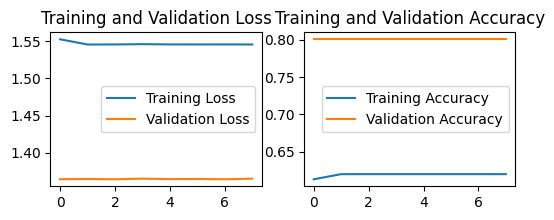

In [14]:
# Plot Train History
epochs_range = range(len(train_losses))

plt.figure(figsize=(6, 2))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

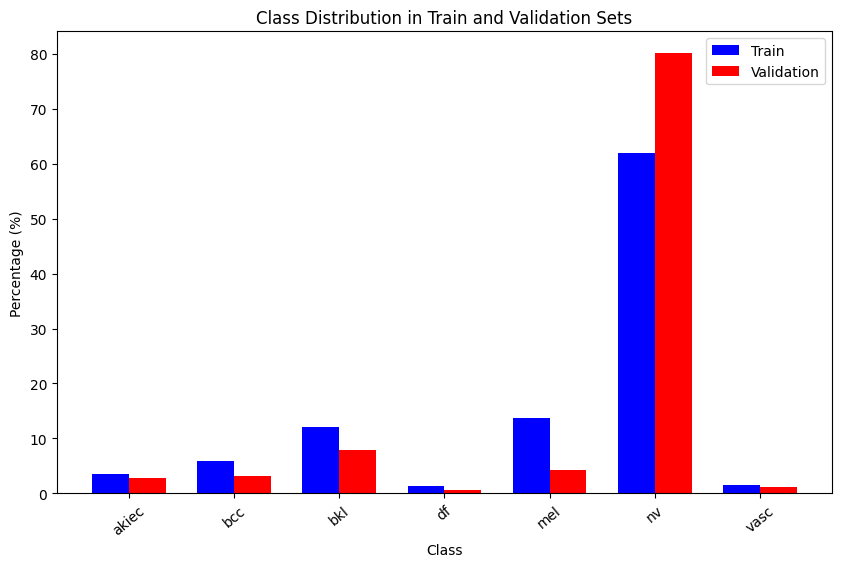

In [15]:
# Display Class distributions
# Calculate percentage distribution for train and validation sets
train_percentage = train['dx_idx'].value_counts(normalize=True) * 100
val_percentage = val['dx_idx'].value_counts(normalize=True) * 100

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

width = 0.35  # width of the bars
x = range(len(class_idx_dict))

train_percentage = train_percentage.reindex(x)
val_percentage = val_percentage.reindex(x)

# Plot bars for train set
ax.bar(x, train_percentage, width, label='Train', color='blue')

# Plot bars for validation set
ax.bar([p + width for p in x], val_percentage, width, label='Validation', color='red')

# Adding labels and title
ax.set_xlabel('Class')
ax.set_ylabel('Percentage (%)')
ax.set_title('Class Distribution in Train and Validation Sets')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels([idx_class_dict[i] for i in x],rotation=40)

# Adding legend
ax.legend()

# Show plot
plt.show()

In [16]:
print(f"Baseline Accuracy to be surpassed in train: {sum(train['dx'] =='nv')/len(train)*100:.4f} %")
print(f"Baseline Accuracy to be surpassed in val: {sum(val['dx'] =='nv')/len(val)*100:.4f} %")

Baseline Accuracy to be surpassed in train: 61.9730 %
Baseline Accuracy to be surpassed in val: 80.0758 %


In [17]:
# Verification that the model is indeed only predicting the majority class
model.eval()
model.cuda()

predictions = []

with torch.no_grad():
    # Iterate over batches in the validation set
    for i, batch in enumerate(val_loader):
        imgs, labels = batch
        imgs = imgs.cuda()
        labels = labels.cuda()
        preds = model(imgs)
        predictions.extend(preds.cpu().detach().numpy())

preds = pd.Series(np.argmax(predictions, axis=1))
print(preds.value_counts())
print("Predicted classes:", [idx_class_dict[i] for i in preds.value_counts().index])

5    1847
Name: count, dtype: int64
Predicted classes: ['nv']


# Findings

- Model only predicts majority class. Hard to learn the patterns of the minority classes if one class is strongly overrepresented in the train set. Gradient information for weight updates favoring minority classes ignored when sharing batches with majority class.
- We will therefore handle class imbalance next. Possible startegies are undersampling majority class, oversampling minority classes or adding class weights to the loss function which increases loss magnitude for minority classes.

In [18]:
# Train set rebalancing: Oversampling minority classes
all_classes = train["dx"].unique()
sample_size = 5000
train_bal = []

for class_ in all_classes:
    cls_data = train[train["dx"] == class_]
    sampled_data = cls_data.sample(sample_size, replace=True)
    train_bal.append(sampled_data)

train_bal = pd.concat(train_bal)
train_bal = train_bal.reset_index(drop=True)
train_bal["dx"].value_counts(normalize=True)

dx
bkl      0.142857
nv       0.142857
df       0.142857
mel      0.142857
vasc     0.142857
bcc      0.142857
akiec    0.142857
Name: proportion, dtype: float64

# Training

In [19]:
# Set up data loading for the new balanced training set
train_data = CustomDataset(train_bal, 'train', transforms)
train_loader = DataLoader(train_data, batch_size=bs, shuffle=True)

# initialize new model
model = ResNet()

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

trainer = Trainer(model=model,
                  crit=criterion,
                  optim=optimizer,
                  train_dl=train_loader,
                  val_test_dl=val_loader,
                  cuda=True,
                  early_stopping_patience=esp)
trainer.lr_scheduler()

# Call fit on trainer
train_losses, val_losses, train_accuracies, val_accuracies = trainer.fit(epochs)

Epoch: 1
	Training Loss: 1.6908491295260093, Training Accuracy: 0.4699714285714286
	Validation Loss: 1.6120094718604252, Validation Accuracy: 0.5538711423930699
Epoch: 2
	Training Loss: 1.5856763521103798, Training Accuracy: 0.5784857142857143
	Validation Loss: 1.4364107949980374, Validation Accuracy: 0.7282079047103411
Epoch: 3
	Training Loss: 1.5145572724682321, Training Accuracy: 0.6512
	Validation Loss: 1.5127721860490997, Validation Accuracy: 0.6469951272333514
Epoch: 4
	Training Loss: 1.441326259477047, Training Accuracy: 0.7256857142857143
	Validation Loss: 1.3897986966988136, Validation Accuracy: 0.7769355711965349
Epoch: 5
	Training Loss: 1.3864692516039232, Training Accuracy: 0.7802
	Validation Loss: 1.3976271419689572, Validation Accuracy: 0.7639415268002165
Epoch: 6
	Training Loss: 1.335393882211863, Training Accuracy: 0.8315428571428571
	Validation Loss: 1.3976327715248897, Validation Accuracy: 0.7623172712506767
Epoch: 7
	Training Loss: 1.301838129050553, Training Accurac

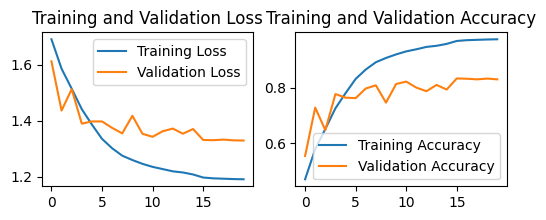

In [20]:
# Plot Train History
epochs_range = range(len(train_losses))

plt.figure(figsize=(6, 2))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [21]:
model.eval()
model.cuda()

predictions = []

with torch.no_grad():
    # Iterate over batches in the validation set
    for i, batch in enumerate(val_loader):
        imgs, labels = batch
        imgs = imgs.cuda()
        labels = labels.cuda()
        preds = model(imgs)
        predictions.extend(preds.cpu().detach().numpy())

preds = pd.Series(np.argmax(predictions, axis=1))
print(preds.value_counts())
print("Predicted classes:", [idx_class_dict[i] for i in preds.value_counts().index])

5    1516
2     125
4      97
1      50
0      26
6      20
3      13
Name: count, dtype: int64
Predicted classes: ['nv', 'bkl', 'mel', 'bcc', 'akiec', 'vasc', 'df']


# Findings

- Rebalancing of the training set enabled model learning. Model does not only predict the majority class but all 7 classes on the validation set.
- However, compared to the baseline (only predicting the majority class) the performance on the validation set did not yet improve by a lot. This could be due to overfitting on the training examples and a limited ability to generalise to new data.
- Therefore data augmentation is employed next. By confronting the model with a bigger corpus of related examples, it should learn more general features. We stick to 'non-destructive' augmentation methods as they usually perform best.

# Image Augmentations

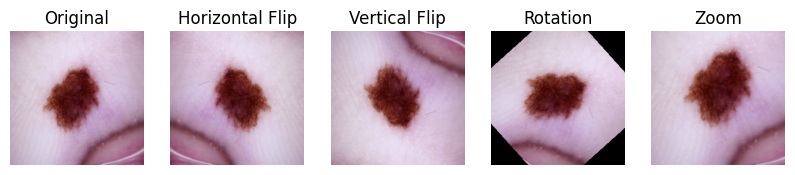

In [22]:
augmentations = {
    "Original": tv.transforms.RandomHorizontalFlip(p=0),
    "Horizontal Flip": tv.transforms.RandomHorizontalFlip(p=1),     # Horizontal flip
    "Vertical Flip": tv.transforms.RandomVerticalFlip(p=1),     # Vertical flip
    "Rotation": tv.transforms.RandomRotation(180),            # Rotate by 30 degrees
    "Zoom": tv.transforms.RandomResizedCrop(size=IMG_SIZE, scale=(0.7, 0.7))  # Random crop
}

# Plotting augmentations
img_p = list(val[val["dx"]=="mel"]["path"])[2]

fig, axs = plt.subplots(1, 5, figsize=(10, 6))

for i, aug in enumerate(augmentations):
    img = Image.open(img_p)
    img = tv.transforms.Resize(IMG_SIZE)(img)
    img = augmentations[aug](img)
    axs[i].imshow(img)
    axs[i].axis("off")
    axs[i].set_title(aug)
    
plt.show()

In [23]:
# Standard transforms
transforms = tv.transforms.Compose([
    tv.transforms.ToPILImage(),
    tv.transforms.Resize(IMG_SIZE),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(IMG_MEAN, IMG_STD)
])

# Train transforms
transforms_train = tv.transforms.Compose([
    tv.transforms.ToPILImage(),
    tv.transforms.Resize(IMG_SIZE),
    tv.transforms.RandomHorizontalFlip(p=0.5),
    tv.transforms.RandomVerticalFlip(p=0.5),
    tv.transforms.RandomRotation(180),
    tv.transforms.RandomResizedCrop(size=IMG_SIZE, scale=(0.7, 1)),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(IMG_MEAN, IMG_STD)
])

# Training

In [24]:
# Set up data loading for the new balanced training set
train_data = CustomDataset(train_bal, 'train', transforms_train)
train_loader = DataLoader(train_data, batch_size=bs, shuffle=True)

# initialize new model
model = ResNet()

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

trainer = Trainer(model=model,
                  crit=criterion,
                  optim=optimizer,
                  train_dl=train_loader,
                  val_test_dl=val_loader,
                  cuda=True,
                  early_stopping_patience=esp)
trainer.lr_scheduler()

# Call fit on trainer
train_losses, val_losses, train_accuracies, val_accuracies = trainer.fit(epochs)

Epoch: 1
	Training Loss: 1.699647550935937, Training Accuracy: 0.4578
	Validation Loss: 1.5045305963220268, Validation Accuracy: 0.654574986464537
Epoch: 2
	Training Loss: 1.633687647975559, Training Accuracy: 0.5279142857142857
	Validation Loss: 1.560696342895771, Validation Accuracy: 0.6020573903627504
Epoch: 3
	Training Loss: 1.6048673110208738, Training Accuracy: 0.5560857142857143
	Validation Loss: 1.4915638977083667, Validation Accuracy: 0.668651867893882
Epoch: 4
	Training Loss: 1.578363366602108, Training Accuracy: 0.5842285714285714
	Validation Loss: 1.5070116581587956, Validation Accuracy: 0.6578234975636167
Epoch: 5
	Training Loss: 1.5565570275787897, Training Accuracy: 0.6064571428571428
	Validation Loss: 1.4428450218562423, Validation Accuracy: 0.7162966973470493
Epoch: 6
	Training Loss: 1.536341471253627, Training Accuracy: 0.6264
	Validation Loss: 1.418815396983048, Validation Accuracy: 0.7406605305901461
Epoch: 7
	Training Loss: 1.5227311508529147, Training Accuracy: 0.

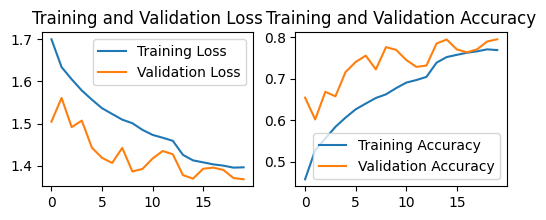

In [25]:
# Plot Train History
epochs_range = range(len(train_losses))

plt.figure(figsize=(6, 2))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Findings

- Performance improved while train- and validation loss diverges less.
- Performance might still be improved by larger architectures and pretrained weights.
- Therefore we will employ a pretrained ResNet Architecture and fine-tune the classification head.

# Modeling: pretrained Resnet Architecture

In [26]:
from torch import nn

#Pretrained model
num_classes = 7
model_pretrained = models.resnet34(pretrained=True)
classifier = nn.Sequential(
                nn.Dropout(p=0.1), # regularisation
                
                # Common practise to set nn.Linear with no bias if using batchnorm after it.
                # As batchnorm normalises activitations from nn.Linear, it also removes the bias from nn.Linear,
                # and it adds its own bias term. Thus, nn.Linear bias term is redundant.
                
                nn.Linear(model_pretrained.fc.in_features, 256, bias=False), 
                nn.ReLU(),
                nn.BatchNorm1d(256),

                nn.Linear(256, 128, bias=False),
                nn.ReLU(),
                nn.BatchNorm1d(128),

                nn.Linear(128, num_classes, bias=False),
                nn.BatchNorm1d(num_classes), 
            )
model_pretrained.fc = classifier

model_pretrained.to("cuda")

# Freezing pretrained CNN backbone for classifier head fine tuning
for p in model_pretrained.parameters():
    p.requires_grad=False

# print(model)
for p in model_pretrained.fc.parameters():
    p.requires_grad=True

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 142MB/s]


# Training

In [27]:
# ImageNet dist
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

# Standard transforms
transforms = tv.transforms.Compose([
    tv.transforms.ToPILImage(),
    tv.transforms.Resize(IMG_SIZE),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(IMG_MEAN, IMG_STD)
])

# Train transforms
transforms_train = tv.transforms.Compose([
    tv.transforms.ToPILImage(),
    tv.transforms.Resize(IMG_SIZE),
    tv.transforms.RandomHorizontalFlip(p=0.5),
    tv.transforms.RandomVerticalFlip(p=0.5),
    tv.transforms.RandomRotation(180),
    tv.transforms.RandomResizedCrop(size=IMG_SIZE, scale=(0.7, 1)),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(IMG_MEAN, IMG_STD)
])

In [28]:
# Set up data loading for the new balanced training set
train_data = CustomDataset(train_bal, 'train', transforms_train)
val_data = CustomDataset(val, 'val', transforms)

train_loader = DataLoader(train_data, batch_size=bs, shuffle=True)
val_loader = DataLoader(val_data, batch_size=bs, shuffle=True)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pretrained.parameters(), lr=lr)

trainer = Trainer(model=model_pretrained,
                  crit=criterion,
                  optim=optimizer,
                  train_dl=train_loader,
                  val_test_dl=val_loader,
                  cuda=True,
                  early_stopping_patience=esp)
trainer.lr_scheduler()

# Call fit on trainer
train_losses, val_losses, train_accuracies, val_accuracies = trainer.fit(epochs)

Epoch: 1
	Training Loss: 1.1102713661939179, Training Accuracy: 0.6023142857142857
	Validation Loss: 0.6983087057697361, Validation Accuracy: 0.7839740119112074
Epoch: 2
	Training Loss: 0.9521432619753006, Training Accuracy: 0.6555142857142857
	Validation Loss: 0.7219283313586794, Validation Accuracy: 0.7688142934488359
Epoch: 3
	Training Loss: 0.8799873739753389, Training Accuracy: 0.6787142857142857
	Validation Loss: 0.5990315603798834, Validation Accuracy: 0.8002165674066053
Epoch: 4
	Training Loss: 0.8412292637271462, Training Accuracy: 0.6915142857142857
	Validation Loss: 0.7166149004780012, Validation Accuracy: 0.7785598267460747
Epoch: 5
	Training Loss: 0.8034619709146524, Training Accuracy: 0.7037714285714286
	Validation Loss: 0.6120087375928616, Validation Accuracy: 0.7845154304277207
Epoch: 6
	Training Loss: 0.7729898528272534, Training Accuracy: 0.7135428571428571
	Validation Loss: 0.6397540702902037, Validation Accuracy: 0.7807255008121278
Epoch: 7
	Training Loss: 0.7673887

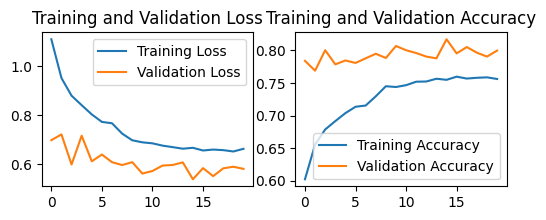

In [29]:
# Plot Train History
epochs_range = range(len(train_losses))

plt.figure(figsize=(6, 2))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Model Evaluation on test set

In [30]:
test_data = CustomDataset(test, 'test', transforms)
test_loader = DataLoader(test_data, batch_size=bs, shuffle=True)

model_pretrained.eval()
model_pretrained.cuda()

predictions = []
gt = [] 

with torch.no_grad():
    # Iterate over batches in the validation set
    for i, batch in enumerate(test_loader):
        imgs, labels = batch
        imgs = imgs.cuda()
        gt.extend(labels.cpu().detach().numpy())
        preds = model_pretrained(imgs)
        predictions.extend(preds.cpu().detach().numpy())

predictions = np.argmax(np.array(predictions), axis=-1)
gt = np.argmax(np.array(gt), axis=-1)
        
# Generate a classification report
report = classification_report(gt, predictions, target_names=list(labels_encoded.columns))
print(report)

              precision    recall  f1-score   support

       akiec       0.42      0.40      0.41        25
         bcc       0.48      0.69      0.56        29
         bkl       0.55      0.75      0.64        73
          df       0.19      0.57      0.29         7
         mel       0.31      0.55      0.40        38
          nv       0.99      0.88      0.93       728
        vasc       0.67      0.80      0.73        10

    accuracy                           0.83       910
   macro avg       0.52      0.66      0.56       910
weighted avg       0.89      0.83      0.85       910



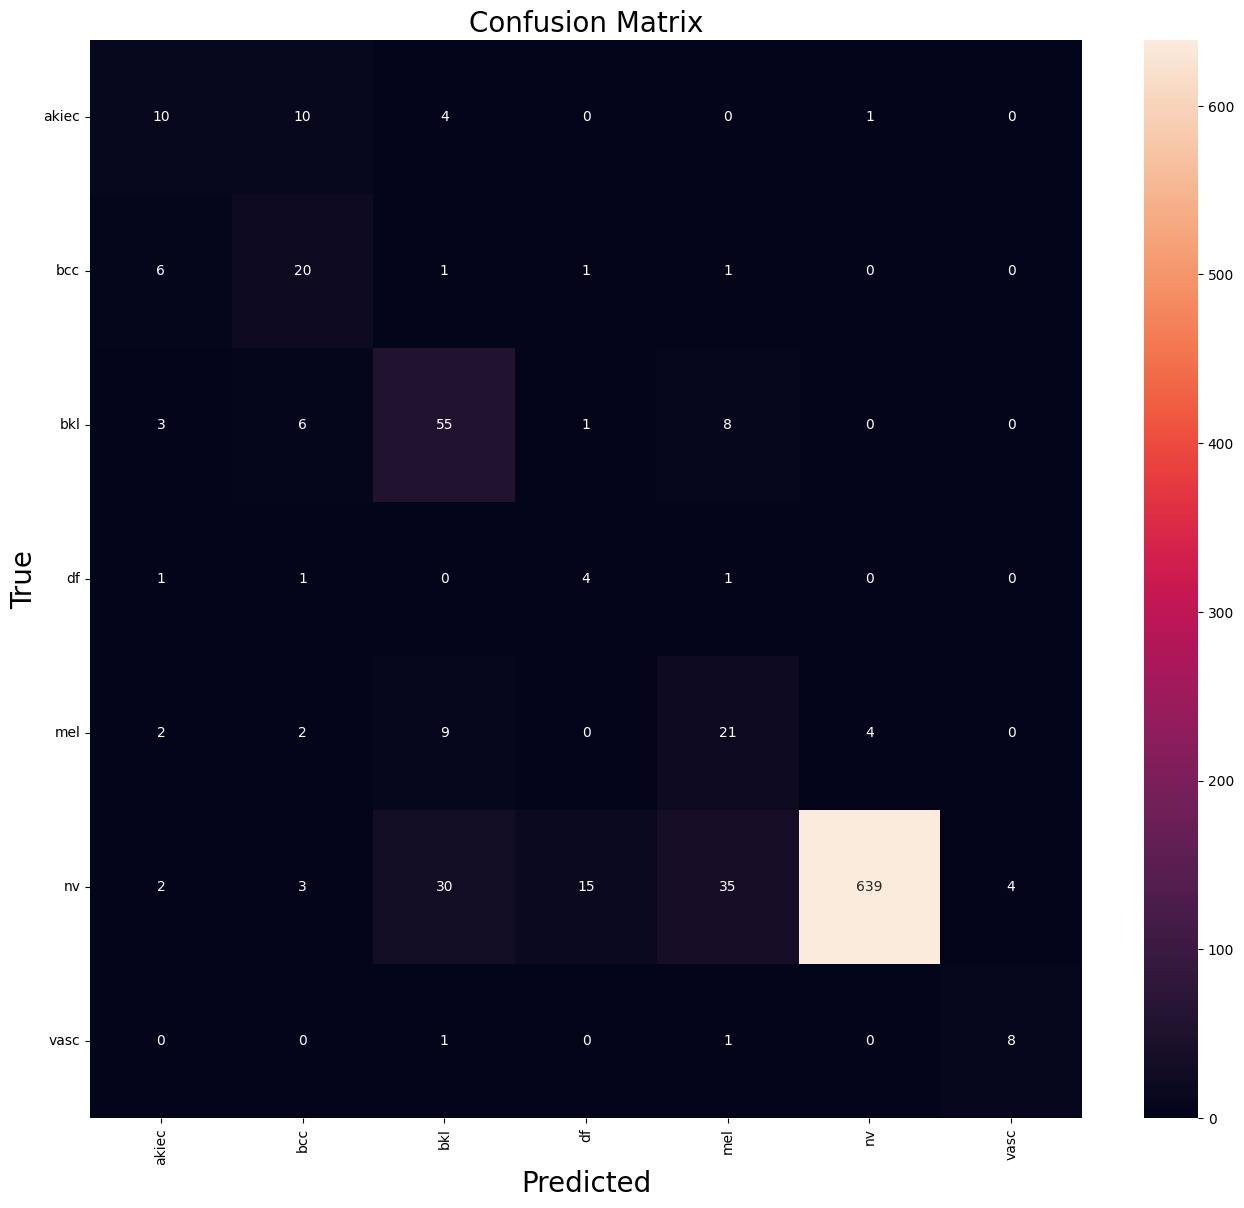

In [31]:
# Confusion Matrix
cm = confusion_matrix(gt, predictions)

## Get Class Labels
class_names = list(labels_encoded.columns)

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix', fontsize=20)
plt.show()